In [3]:
%load_ext autoreload
%autoreload 2
import os

import yaml
import glob
import logging
import numpy as np
from importlib import reload  # Not needed in Python 2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset
import seaborn as sns


from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

voc_idx = np.array([0,2,3,4,8,9,10] + list(range(32,51)))
### grad limit!!!
def hook_fn(bn,input_grad,output_grad):
    # print(module)
    # for g in input_grad: print('input grad shape: {}'.format(g.size()))
    # for g in output_grad: print('output grad shape: {}'.format(g.size()))

    std = bn.running_var

    t_grad = input_grad[0]*torch.sqrt(std + 1e-5).view(-1,1,1)
    mean_grad = torch.mean(t_grad[:,voc_idx,:,:],dim=1,keepdim=True)

    t_grad[:,np.array(voc_idx),:,:] = mean_grad

    x_grad = t_grad/torch.sqrt(std + 1e-5).view(-1,1,1)

    return (x_grad,input_grad[1],input_grad[2])


# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')



class Focal_loss_regression(nn.Module):
    def __init__(self,max_update=10,_lambda=2,):
        super(Focal_loss_regression,self).__init__()
        self._lambda = _lambda
        max_update = np.power(1/max_update,1/_lambda)
        max_update = 1/max_update
        max_update = 1/(max_update-1)
        self.max_update = max_update
        
    def forward(self,pred,target):
        diff_abs = torch.abs(pred-target)
        diff_max = (1+self.max_update)*torch.max(diff_abs)
#         diff_max.detach()
        rate = torch.pow((1-1/diff_max*diff_abs)**self._lambda,-1)
        diff_abs = rate*diff_abs
        
#         return diff_abs
        return torch.mean(diff_abs)

In [1]:
import sys
sys.path.append( '/anaconda/envs/py37_pytorch/lib/python3.7')
sys.path.append('/anaconda/envs/py37_pytorch/lib/python3.7/site-packages')
sys.path.append('/home/v-zeyyan/.local/lib/python3.6/site-packages')

In [2]:
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import cm as CM
from PIL import Image
import h5py
import numpy as np
import cv2
from util.im_visualization import *

In [4]:
%matplotlib inline
def show_station_diff(month_idx = 0):

    for month in [month_idx]:
        for p in range(len(Data.pollution_idx)):
            p_name = pollution[p]

            month_obs = Data.obs_label[month][24:,p].copy()
            month_nn = Data.finetune_label[month][24:,p].copy()
            month_ctm = Data.label[month][24:,p].copy()

#             print(month_ctm.shape)
#             print(month_nn.shape)
#             print(month_obs.shape)
            month_ctm = month_ctm[528:]
            month_nn = month_nn[528:]
            month_obs = month_obs[528:]
#             print(month_ctm.shape)
#             print(month_nn.shape)
#             print(month_obs.shape)

            count = np.sum(month_obs==-999)
            
            # pixel with no obersertion -> 0
            month_ctm[month_obs==-999] = 0
            month_nn[month_obs==-999] = 0
            month_obs[month_obs==-999] = 0
            
            MAE = np.sum(np.abs(month_ctm-month_nn))/(len(month_ctm)*182*232-count)
            print('MAE: ',MAE)
            
            sum_month_obs = np.sum(month_obs,axis = 0)
            sum_month_nn = np.sum(month_nn,axis = 0)
            sum_month_ctm = np.sum(month_ctm,axis = 0)
            
#             print(sum_month_obs.shape)
#             print(sum_month_nn.shape)
#             print(sum_month_ctm.shape)
            
            plt.rcParams['figure.figsize'] = (10,5)

            a = ((sum_month_nn - sum_month_ctm)/(sum_month_ctm+1))
#             print(sum_month_obs)
            print(a.shape)
            print(a)
#             a = a.reshape((1,42224))
            print(np.mean(np.abs(a)))
#             image_show(a.reshape((1,182,232)))
            a = a[sum_month_obs>0]
            plt.hist(a,bins = 100,range = (-1,1))
            plt.title(f'{p_name}: (nn-ctm)/(1+ctm):{np.mean(np.abs(a))}')
            plt.show()
            

            a = ((sum_month_nn - sum_month_ctm)/(sum_month_obs+1))
#             image_show(a.reshape((1,182,232)))
            a = a[sum_month_obs>0]
            plt.hist(a,bins = 100,range = (-1,1))
            plt.title(f'{p_name}: (nn-ctm)/(1+obs):{np.mean(np.abs(a))}')
            plt.show()

            a = ((sum_month_nn - sum_month_obs)/(sum_month_obs+1))
#             image_show(a.reshape((1,182,232)))
            a = a[sum_month_obs>0]
            plt.hist(a,bins = 100,range = (-1,1))
            plt.title(f'{p_name}: (nn-obs)/(1+obs):{np.mean(np.abs(a))}')
            plt.show()

            a = ((sum_month_ctm - sum_month_obs)/(sum_month_obs+1))
#             image_show(a.reshape((1,182,232)))
            a = a[sum_month_obs>0]
            plt.hist(a,bins = 100,range = (-1,1))
            plt.title(f'{p_name}: (ctm-obs)/(1+obs):{np.mean(np.abs(a))}')
            plt.show()


            plt.rcParams['figure.figsize'] = (15, 5)

#             for b,a,name in [[136,115,'beijing'],[139,112,'tianjin'],[130,107,'shijiazhuang'],[157,76,'ningbo'],[96,99,'lanzhou'],[112,91,'xian'],[48,139,'xinjiang']]:
            for b,a,name in [[114,26,'sanya'],[140,82,'hefei'],[155,81,'shanghai'],[128,46,'guangzhou'],[146,53,'xiamen']]:
                obs = month_obs[:,a,b]
                nn = month_nn[:,a,b]
                ctm = month_ctm[:,a,b]

#                 plt.plot(obs[obs!=-999],'k')
                plt.plot(nn[obs!=-999],'r--')
                plt.plot(ctm[obs!=-999],'g--')

#                 plt.legend(['obs','nn_label','ctm_label'])
                plt.legend(['nn_label','ctm_label'])
                plt.title(p_name + ' : ' + name)
                plt.show()



In [5]:
with open('config/cfg.yaml','r') as f:
    cfg = yaml.load(f)
    
cfg = {**cfg['step2'],**cfg['share_cfg'],**cfg['share_cfg']['data_path']}
T = cfg['T']
pollution = cfg['pollution']
batch_size = cfg['batch_size']

name = cfg['name']
### remove CH4,AACD,ACET
EM_idx = np.array(cfg['EM_idx'])
EM_save_path = cfg['EM_save_path']

print('train data is loading ')
Data = AS_Data_obs(cfg,left = 0,right = 1,window = T,pollution = pollution,EM_idx = EM_idx)
trainloader = DataLoader(Data,batch_size=batch_size,shuffle=True)
print(len(Data))
print(Data.EM_idx)

/home/v-zeyyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


train data is loading 
/AS_data/Conc_npy/TOTAL_2015_10_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
(744, 4, 182, 232)
/AS_data/zeyuan_folder/concat_data/rest_EM_2015_10_744_07_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_10_744_34_182_232.npy   is loading
/AS_data/obs_npy/obs2015_10_744_6_182_232.npy   is loading
720
[1 2 4 5 6]


In [6]:
from model.res_model_LSTM import res8
from model.unet_model_LSTM import UNet
from model.layers import Tensor_Parameter

# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
# test_model = UNet(cfg['meteorological_dim']+cfg['emission_dim'],cfg['grid_dim'],T=T,bilinear=False,pre_dim = len(pollution)) #+80
test_model = res8(cfg['meteorological_dim']+cfg['emission_dim'],cfg['grid_dim'],T=T,pre_dim = len(pollution))
t2p = Tensor_Parameter()


test_model.to(device)
t2p.to(device)
criterion = torch.nn.L1Loss()
# optimizer = torch.optim.SGD(t2p.parameters(),lr=1)
optimizer = torch.optim.Adam(t2p.parameters(),lr=1e-1)
test_model.load_state_dict(torch.load(name))
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

### finetune voc limit
modules = test_model.named_children() # type: generator
# for name,module in modules:
#     if name == 'bn0':
#         print('Name: {}'.format(name))
#         print('Module: {}'.format(module))
#         module.register_backward_hook(hook_fn)


In [7]:
def hook_NO(bn,input_grad,output_grad):
    # print(module)
    # for g in input_grad: print('input grad shape: {}'.format(g.size()))
    # for g in output_grad: print('output grad shape: {}'.format(g.size()))

    std = bn.running_var
    
#     print(std)

    t_grad = input_grad[0]*torch.sqrt(std + 1e-5).view(1,-1,1,1)
    mean_grad = torch.mean(t_grad[:,np.array([2,3]),:,:],dim=1,keepdim=True)
    
#     for i in range(len(mean_grad)): print(torch.mean(mean_grad[i]))
    print('*'*20)
#     print(torch.mean(t_grad))

    t_grad[:,np.array([2,3]),:,:] = mean_grad
    print(t_grad[0,2,10,100:130])
    print(t_grad[0,3,10,100:130])
#     for i in range(182):
#         if torch.mean(t_grad[0,2,0,:]) > 0: 
#             print(i)
#             print(t_grad[0,np.array([2,3]),0,:])
#         print(torch.mean(t_grad[0,2,i,:]))

    x_grad = t_grad/torch.sqrt(std + 1e-5).view(1,-1,1,1)
    
    print(x_grad[0,2,10,100:130])
    print(x_grad[0,3,10,100:130])

    return (x_grad,input_grad[1],input_grad[2])

In [7]:
modules = test_model.named_children()
# print(type(modules))
for name, module in modules:
#     print(f'{name}:{module}')
    if name == 'bn0':
        print(f'Name: {name}')
        print(f'Module: {module}')
        module.register_backward_hook(hook_NO)

Name: bn0
Module: BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [7]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
            input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.float().to(device)
            input = t2p(input)
            y_pred = model(input,grid,yt_1)
            
            Data.update_labels(indexes,y_pred)
            if torch.sum(obs!=-999)==0:
                continue
            
            cur_loss = []
            for pollution in range(y_pred.shape[1]):
                cur_pred = y_pred[:,pollution]
                cur_obs = obs[:,pollution]
                loss = criterion(cur_pred[cur_obs!=-999],cur_obs[cur_obs!=-999])
                cur_loss.append(loss.cpu().data)
            ls.append(cur_loss)
    return np.mean(np.array(ls),axis = 0)

MAE:  11.804369714526
(182, 232)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0027402467


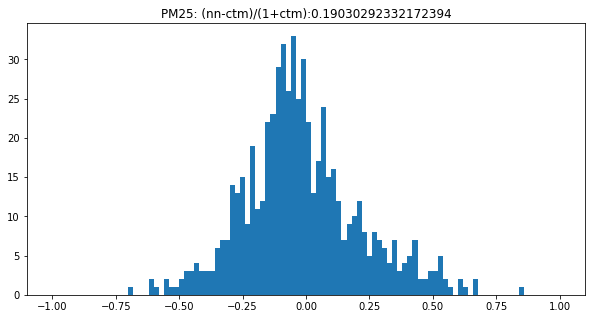

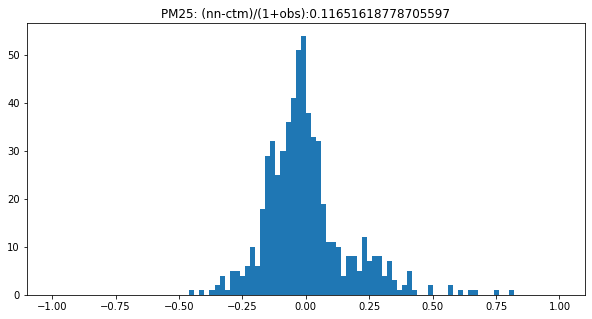

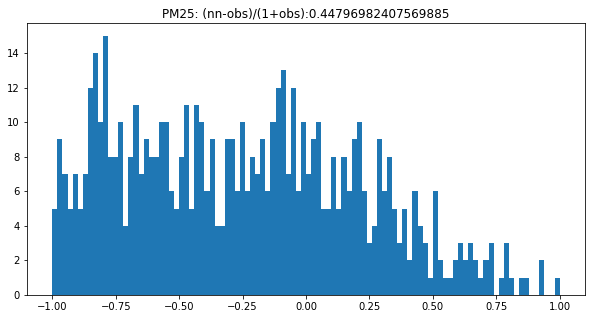

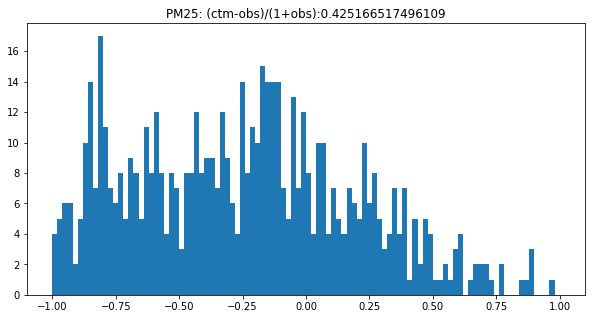

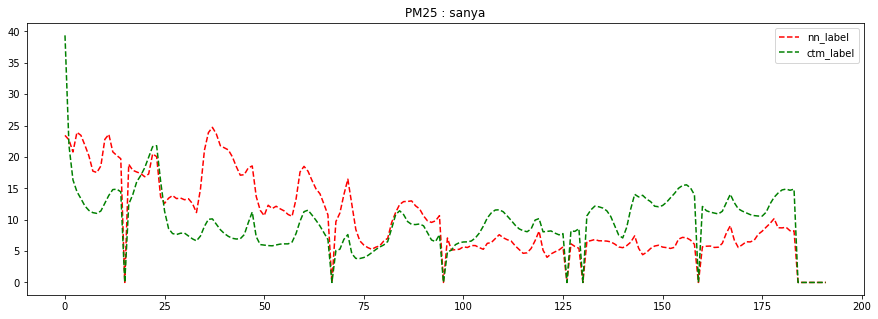

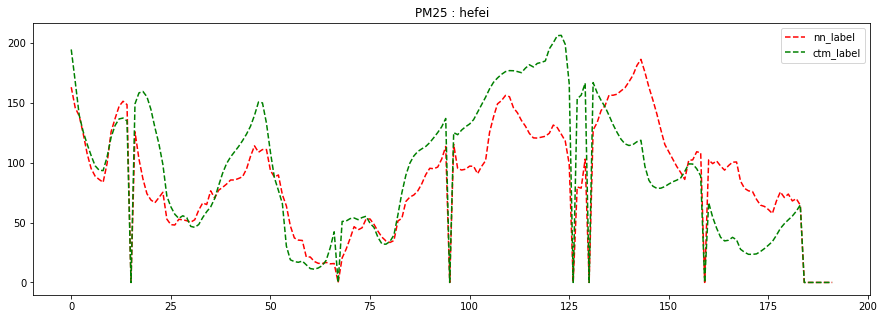

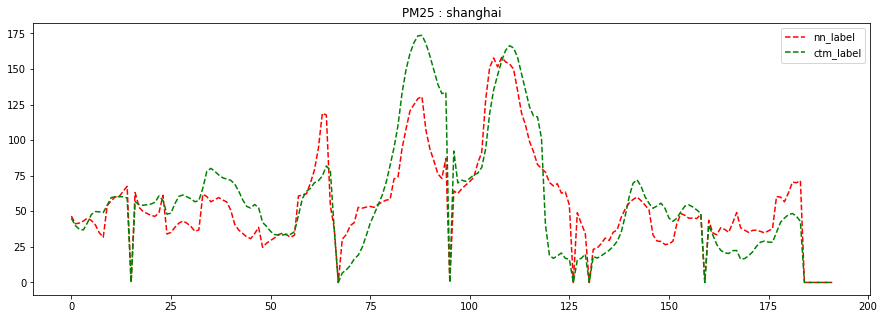

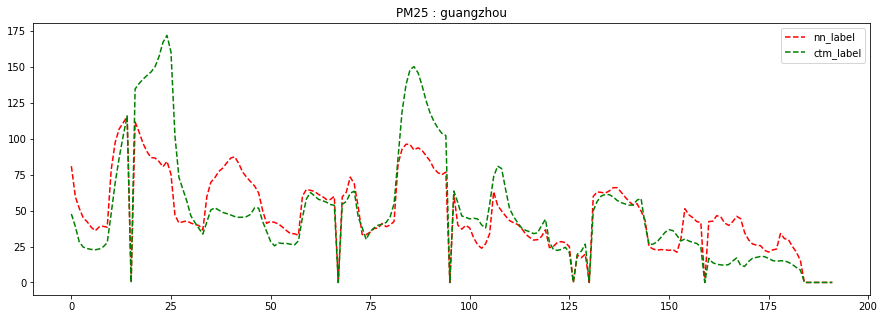

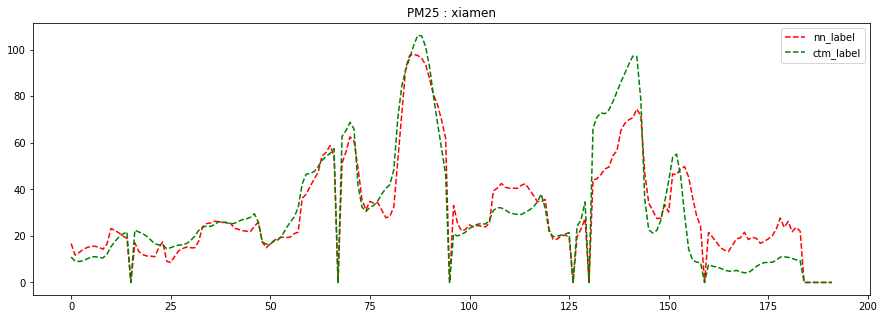

MAE:  5.884893596616799
(182, 232)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.001383643


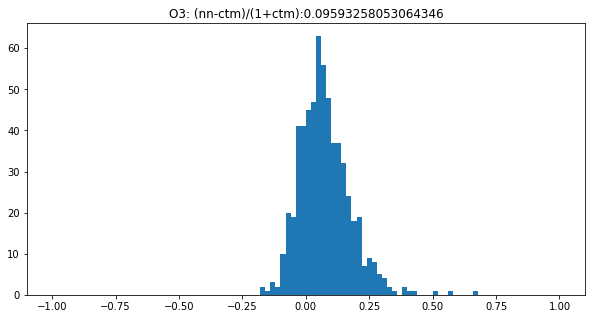

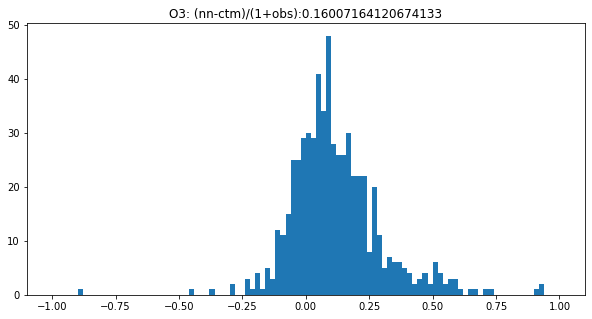

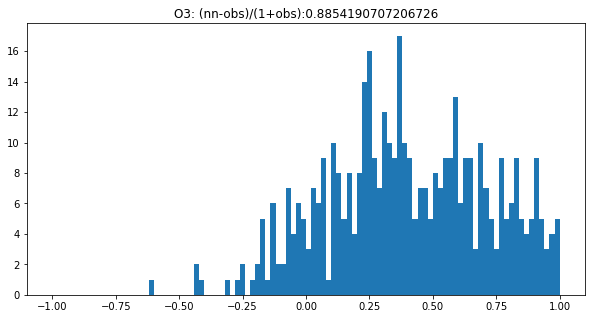

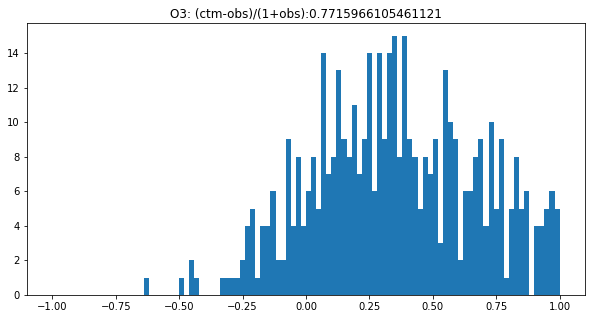

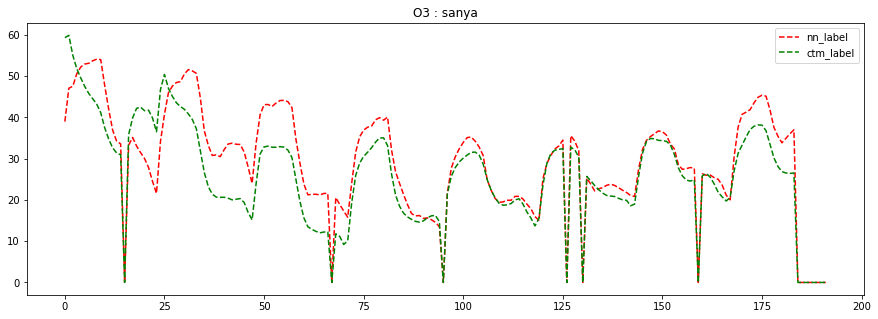

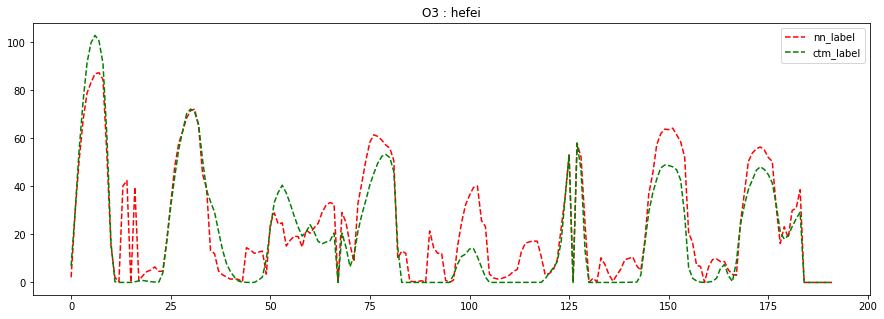

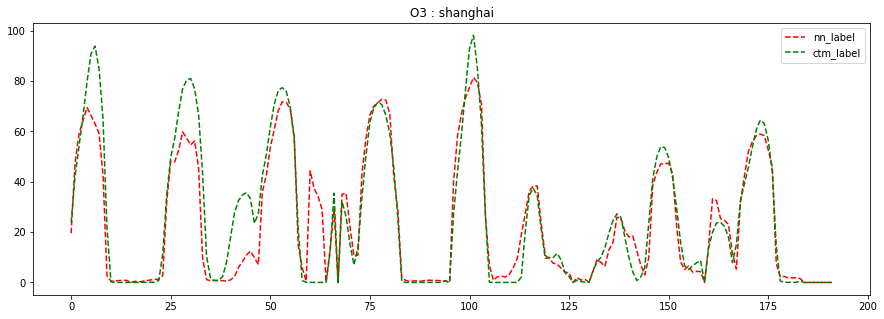

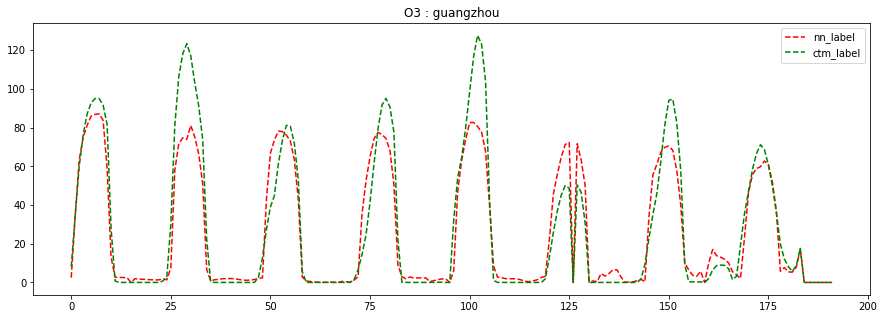

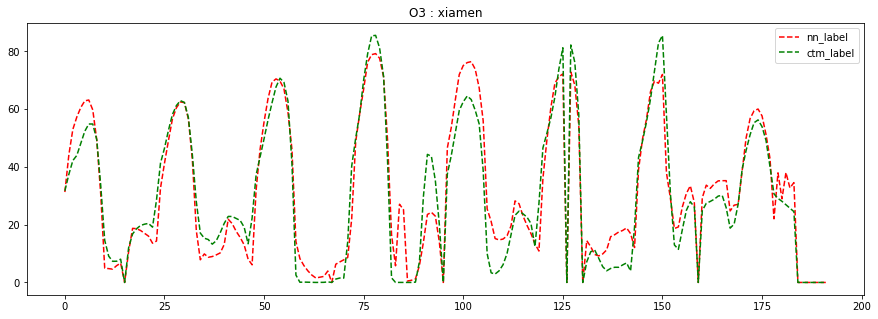

MAE:  3.421211046511628
(182, 232)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0021193568


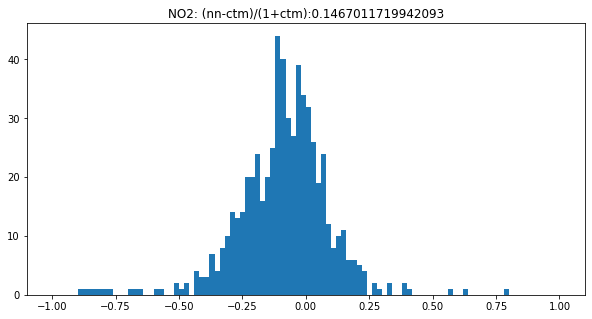

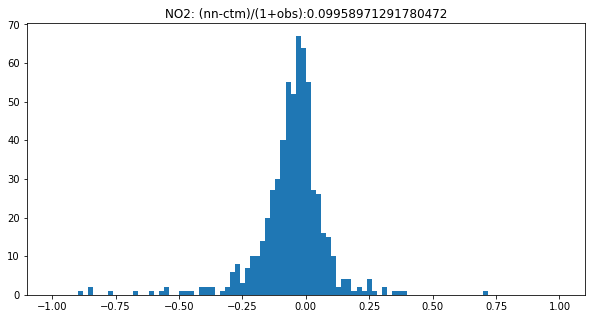

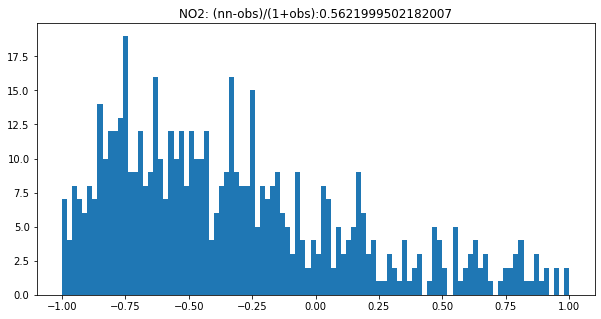

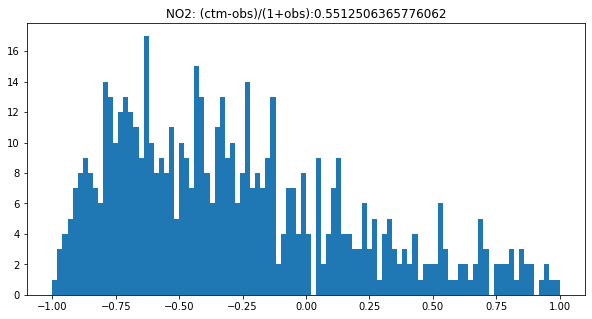

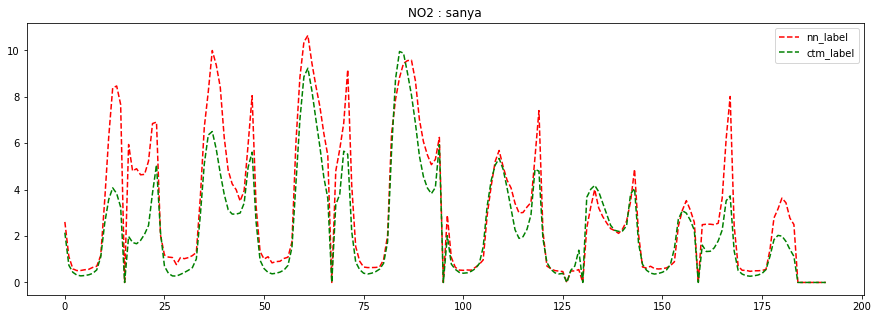

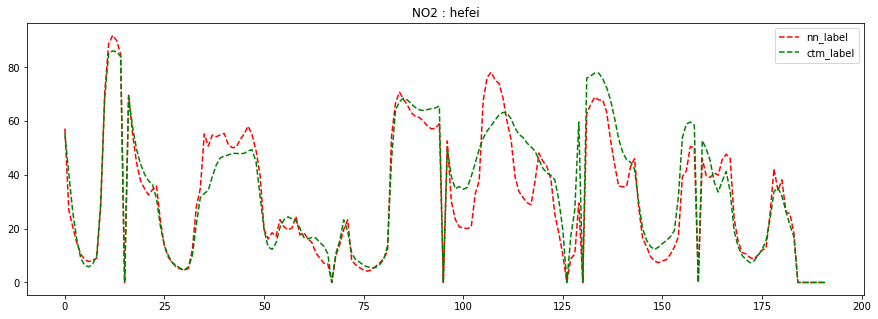

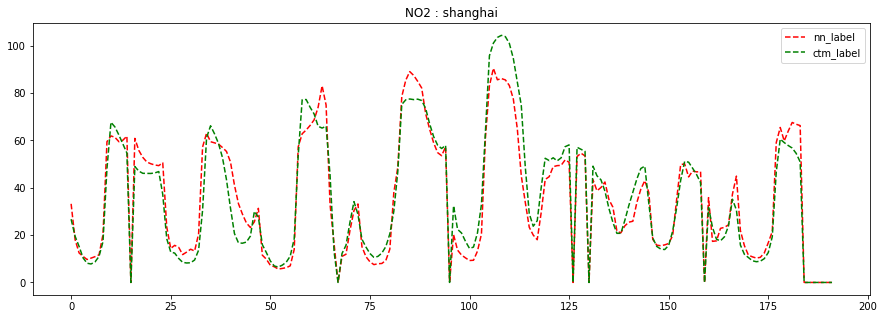

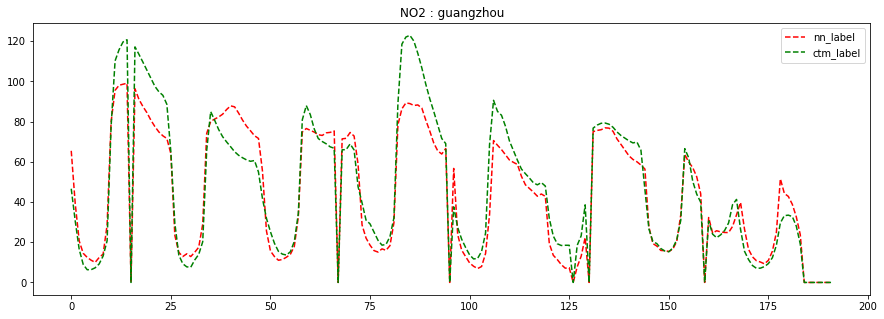

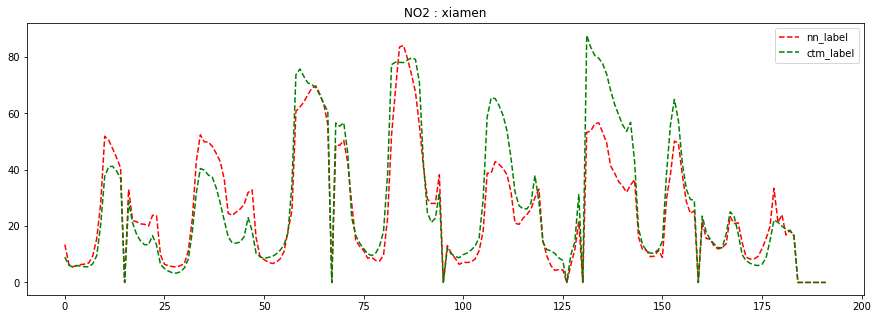

MAE:  1.921051890320962
(182, 232)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.024021976


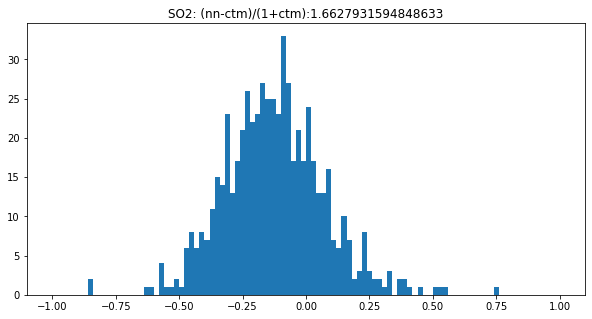

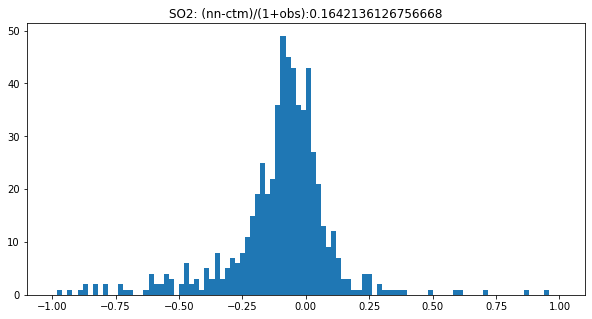

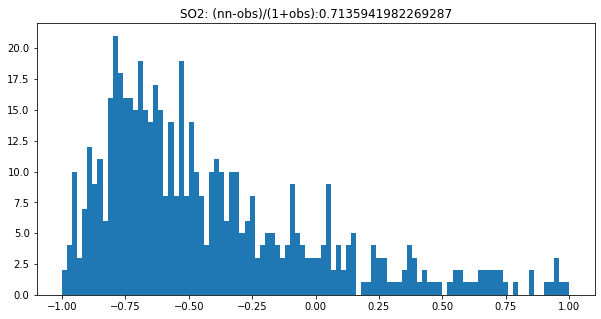

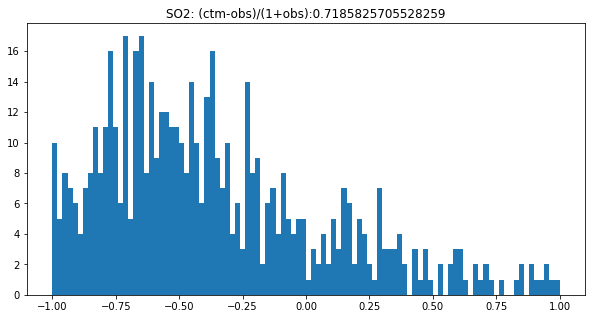

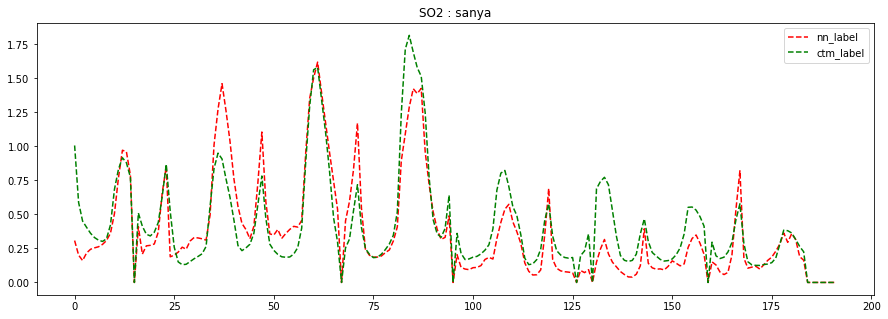

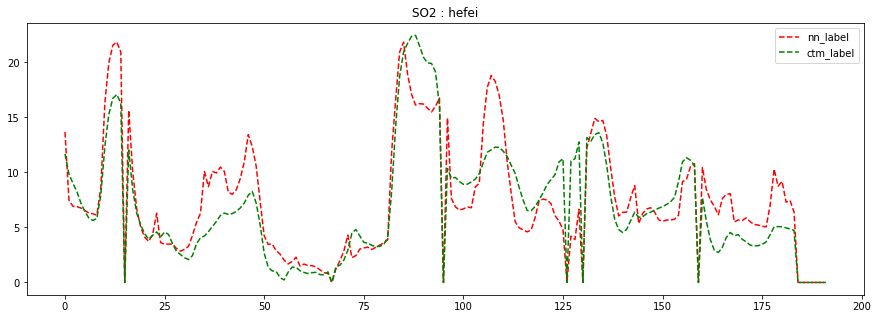

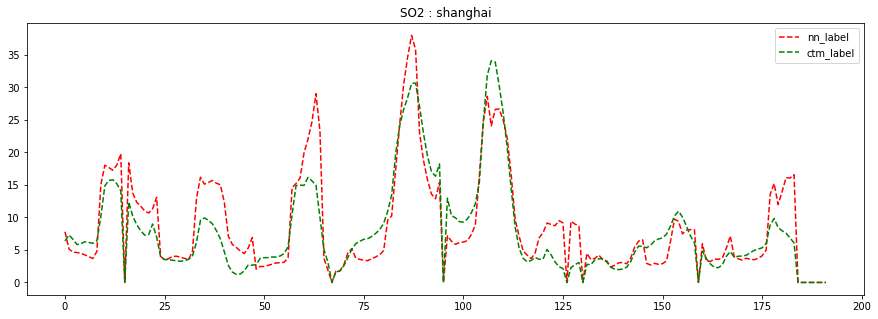

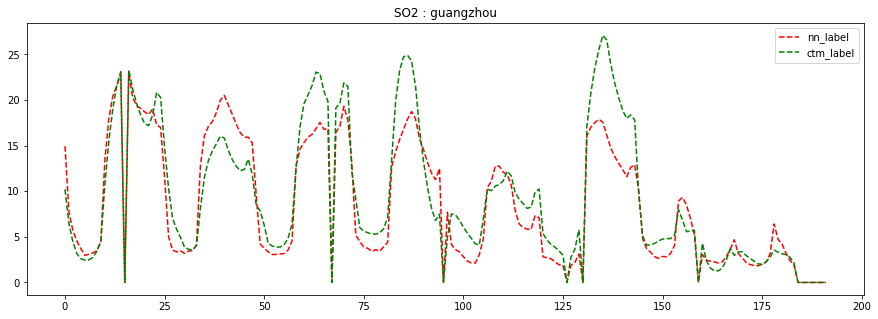

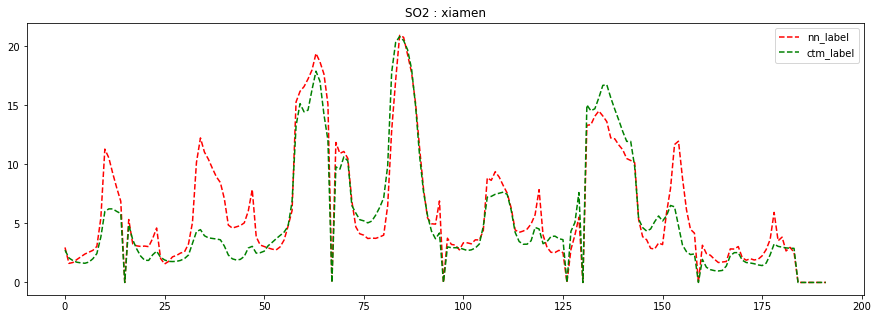

In [8]:
test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss())
# logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))

show_station_diff()

In [7]:
for epoch in range(25):
#     logging.info('-----------{}-----------'.format(epoch))
    print('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.eval()
    test_model.rnn.train()
    for idx,i in enumerate(trainloader):
        
        indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
        input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.to(device)
        input = t2p(input)
        y_pred = test_model(input,grid,yt_1)

        if torch.sum(obs!=-999)==0:
            continue
        optimizer.zero_grad()
        
        loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        
        #udpate input parameter
        Data.update(indexes,t2p.Input.data)
#         Data.update_labels(indexes,y_pred)
        if len(ls)%400==0:
#             logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
            print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
#     logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
#     logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))
    print('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))
#     if epoch%3 == 0:
#         test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
#         logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))

    if epoch%1 == 0:
#         for _idx,month in enumerate(['01','02','04','07','10'][:len(Data.EM)]):
        for _idx,month in enumerate(['01'][:len(Data.EM)]):
            if not os.path.exists(EM_save_path):
                os.mkdir(EM_save_path)
#             print(idx)
            np.save(EM_save_path+'/rest_NO_4month_{}_finetune_input.npy'.format(month),Data.EM[_idx])
#             np.save('month_{}_finetune_input.npy'.format(month),Data.EM[_idx])

-----------0-----------
********************
tensor([-8.9390e-09,  1.2121e-08, -1.3237e-08, -1.8098e-08,  4.0388e-08,
         1.5312e-08, -7.4083e-09,  1.5085e-09, -4.7780e-09, -2.8487e-08,
         7.7196e-09,  2.8372e-08, -3.2026e-08, -3.7507e-08,  1.0288e-07,
         8.3196e-08,  4.3533e-08,  8.1211e-08,  7.3969e-08,  3.3885e-08,
         4.5621e-08,  5.0043e-08,  3.9172e-08,  2.6407e-08,  5.9412e-09,
         8.0008e-09,  3.5317e-10,  5.5051e-10,  4.4909e-10,  4.0379e-10],
       device='cuda:0')
tensor([-8.9390e-09,  1.2121e-08, -1.3237e-08, -1.8098e-08,  4.0388e-08,
         1.5312e-08, -7.4083e-09,  1.5085e-09, -4.7780e-09, -2.8487e-08,
         7.7196e-09,  2.8372e-08, -3.2026e-08, -3.7507e-08,  1.0288e-07,
         8.3196e-08,  4.3533e-08,  8.1211e-08,  7.3969e-08,  3.3885e-08,
         4.5621e-08,  5.0043e-08,  3.9172e-08,  2.6407e-08,  5.9412e-09,
         8.0008e-09,  3.5317e-10,  5.5051e-10,  4.4909e-10,  4.0379e-10],
       device='cuda:0')
tensor([-4.9624e-09,  6.7287e

********************
tensor([ 2.7316e-07,  1.3750e-07, -6.9696e-08, -1.1939e-07,  1.2647e-07,
         1.6144e-06,  1.3129e-06, -3.9648e-08,  1.0645e-06, -1.3040e-08,
        -1.2177e-06, -1.6940e-06, -3.7837e-06,  3.5499e-07,  2.3595e-07,
        -3.1041e-07, -7.4967e-07,  3.3478e-07,  7.9940e-07,  8.5150e-07,
         1.9674e-06,  1.7084e-06,  1.8274e-06,  8.6607e-07,  5.0694e-07,
         3.3463e-07,  2.5712e-07,  4.3235e-08,  2.3169e-08,  2.6323e-08],
       device='cuda:0')
tensor([ 2.7316e-07,  1.3750e-07, -6.9696e-08, -1.1939e-07,  1.2647e-07,
         1.6144e-06,  1.3129e-06, -3.9648e-08,  1.0645e-06, -1.3040e-08,
        -1.2177e-06, -1.6940e-06, -3.7837e-06,  3.5499e-07,  2.3595e-07,
        -3.1041e-07, -7.4967e-07,  3.3478e-07,  7.9940e-07,  8.5150e-07,
         1.9674e-06,  1.7084e-06,  1.8274e-06,  8.6607e-07,  5.0694e-07,
         3.3463e-07,  2.5712e-07,  4.3235e-08,  2.3169e-08,  2.6323e-08],
       device='cuda:0')
tensor([ 1.5164e-07,  7.6331e-08, -3.8691e-08, -6.627

********************
tensor([ 5.8278e-08,  1.1860e-08,  8.1771e-08,  4.9704e-07,  2.3611e-07,
         2.3889e-07,  4.9169e-07,  2.4799e-07,  2.0670e-07, -2.4404e-07,
        -5.7736e-07, -6.7588e-07, -7.0431e-07, -9.9598e-07, -9.6884e-07,
        -9.5166e-07, -7.5783e-07, -5.5593e-07, -2.1052e-08,  3.9364e-07,
         3.1169e-07,  2.0416e-07,  1.7295e-07,  9.6254e-08,  5.3878e-08,
         2.0923e-08,  4.3640e-08,  2.2158e-08,  3.2040e-09,  9.8544e-10],
       device='cuda:0')
tensor([ 5.8278e-08,  1.1860e-08,  8.1771e-08,  4.9704e-07,  2.3611e-07,
         2.3889e-07,  4.9169e-07,  2.4799e-07,  2.0670e-07, -2.4404e-07,
        -5.7736e-07, -6.7588e-07, -7.0431e-07, -9.9598e-07, -9.6884e-07,
        -9.5166e-07, -7.5783e-07, -5.5593e-07, -2.1052e-08,  3.9364e-07,
         3.1169e-07,  2.0416e-07,  1.7295e-07,  9.6254e-08,  5.3878e-08,
         2.0923e-08,  4.3640e-08,  2.2158e-08,  3.2040e-09,  9.8544e-10],
       device='cuda:0')
tensor([ 3.2353e-08,  6.5841e-09,  4.5394e-08,  2.759

********************
tensor([ 1.3713e-08,  4.2717e-09,  3.9480e-09,  2.6806e-08,  2.2384e-08,
         2.4091e-08,  1.1307e-08, -4.5862e-08,  6.8745e-09, -3.4659e-09,
         1.0601e-08, -1.6068e-08,  3.1005e-07, -4.6401e-08,  4.0108e-09,
        -1.0018e-07, -6.8059e-08, -3.5527e-08, -8.0619e-08, -5.4331e-08,
        -8.5196e-08, -5.5380e-08, -1.7123e-08,  4.2985e-08,  1.5953e-08,
         5.1533e-09, -7.0577e-09, -7.9081e-09,  1.3095e-09, -5.5086e-09],
       device='cuda:0')
tensor([ 1.3713e-08,  4.2717e-09,  3.9480e-09,  2.6806e-08,  2.2384e-08,
         2.4091e-08,  1.1307e-08, -4.5862e-08,  6.8745e-09, -3.4659e-09,
         1.0601e-08, -1.6068e-08,  3.1005e-07, -4.6401e-08,  4.0108e-09,
        -1.0018e-07, -6.8059e-08, -3.5527e-08, -8.0619e-08, -5.4331e-08,
        -8.5196e-08, -5.5380e-08, -1.7123e-08,  4.2985e-08,  1.5953e-08,
         5.1533e-09, -7.0577e-09, -7.9081e-09,  1.3095e-09, -5.5086e-09],
       device='cuda:0')
tensor([ 7.6126e-09,  2.3714e-09,  2.1917e-09,  1.488

********************
tensor([-8.2000e-08, -4.4869e-08,  3.9694e-08,  2.3425e-07,  2.0117e-08,
        -1.8171e-07, -3.5534e-08, -6.4317e-08, -2.1260e-07, -3.3465e-07,
        -4.5949e-07, -5.1568e-07, -3.1701e-07, -3.1507e-07, -2.4964e-07,
         3.8906e-08,  3.3756e-07,  3.6235e-07,  2.4076e-07,  2.6144e-07,
         9.3137e-08,  2.0486e-07,  3.5109e-07,  3.0300e-07,  1.5591e-07,
         1.6393e-07,  8.1501e-08, -1.3163e-09,  1.5019e-08, -2.5261e-08],
       device='cuda:0')
tensor([-8.2000e-08, -4.4869e-08,  3.9694e-08,  2.3425e-07,  2.0117e-08,
        -1.8171e-07, -3.5534e-08, -6.4317e-08, -2.1260e-07, -3.3465e-07,
        -4.5949e-07, -5.1568e-07, -3.1701e-07, -3.1507e-07, -2.4964e-07,
         3.8906e-08,  3.3756e-07,  3.6235e-07,  2.4076e-07,  2.6144e-07,
         9.3137e-08,  2.0486e-07,  3.5109e-07,  3.0300e-07,  1.5591e-07,
         1.6393e-07,  8.1501e-08, -1.3163e-09,  1.5019e-08, -2.5261e-08],
       device='cuda:0')
tensor([-4.5521e-08, -2.4909e-08,  2.2036e-08,  1.300

********************
tensor([ 8.1449e-08,  1.9535e-07,  2.0845e-07,  2.9017e-07,  3.4447e-07,
         3.8589e-07,  3.2604e-07, -1.6803e-07, -2.1829e-07,  6.8932e-08,
        -2.5816e-07, -5.2818e-07, -1.5305e-06, -1.7237e-06, -1.3636e-06,
        -1.6017e-08, -1.4510e-07,  1.6837e-07,  7.0549e-07,  1.0441e-06,
         1.2842e-06,  1.3321e-07,  5.3244e-07, -4.8564e-08, -2.3067e-07,
        -5.5045e-07, -2.4672e-07, -4.7538e-08, -1.5151e-07, -1.2125e-07],
       device='cuda:0')
tensor([ 8.1449e-08,  1.9535e-07,  2.0845e-07,  2.9017e-07,  3.4447e-07,
         3.8589e-07,  3.2604e-07, -1.6803e-07, -2.1829e-07,  6.8932e-08,
        -2.5816e-07, -5.2818e-07, -1.5305e-06, -1.7237e-06, -1.3636e-06,
        -1.6017e-08, -1.4510e-07,  1.6837e-07,  7.0549e-07,  1.0441e-06,
         1.2842e-06,  1.3321e-07,  5.3244e-07, -4.8564e-08, -2.3067e-07,
        -5.5045e-07, -2.4672e-07, -4.7538e-08, -1.5151e-07, -1.2125e-07],
       device='cuda:0')
tensor([ 4.5216e-08,  1.0845e-07,  1.1572e-07,  1.610

********************
tensor([ 2.1625e-09, -9.7191e-10, -1.0109e-08,  3.4828e-08,  2.6381e-08,
        -1.1130e-08,  7.5203e-08, -1.0489e-07, -2.6547e-08, -1.0236e-08,
        -7.3697e-08, -1.1473e-07, -8.2169e-08,  3.9977e-08,  8.4526e-08,
        -7.2166e-08,  7.1083e-09, -4.0551e-08, -1.8719e-08, -9.4236e-09,
         7.4669e-08,  2.0353e-08,  1.1424e-08, -3.4755e-08, -3.8013e-08,
        -6.7380e-08, -1.1494e-08, -2.5154e-08, -1.3873e-09,  9.6624e-09],
       device='cuda:0')
tensor([ 2.1625e-09, -9.7191e-10, -1.0109e-08,  3.4828e-08,  2.6381e-08,
        -1.1130e-08,  7.5203e-08, -1.0489e-07, -2.6547e-08, -1.0236e-08,
        -7.3697e-08, -1.1473e-07, -8.2169e-08,  3.9977e-08,  8.4526e-08,
        -7.2166e-08,  7.1083e-09, -4.0551e-08, -1.8719e-08, -9.4236e-09,
         7.4669e-08,  2.0353e-08,  1.1424e-08, -3.4755e-08, -3.8013e-08,
        -6.7380e-08, -1.1494e-08, -2.5154e-08, -1.3873e-09,  9.6624e-09],
       device='cuda:0')
tensor([ 1.2005e-09, -5.3955e-10, -5.6117e-09,  1.933

KeyboardInterrupt: 

In [10]:
# np.save('month_{}_finetune_input.npy'.format('01'),Data.EM[0])